<a href="https://colab.research.google.com/github/rizkydianputra/-MACHINE-LEARNING/blob/main/(MINGGU_12)CNN_Batchnormalize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==0.17.0

     |████████████████████████████████| 83 kB 932 kB/s 


In [2]:
import torch
from torch import nn
from d2l import torch as d2l
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # Use `is_grad_enabled` to determine whether the current mode is training
    # mode or prediction mode
    if not torch.is_grad_enabled():
        # If it is prediction mode, directly use the mean and variance
        # obtained by moving average
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # When using a fully-connected layer, calculate the mean and
            # variance on the feature dimension
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # When using a two-dimensional convolutional layer, calculate the
            # mean and variance on the channel dimension (axis=1). Here we
            # need to maintain the shape of `X`, so that the broadcasting
            # operation can be carried out later
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # In training mode, the current mean and variance are used for the
        # standardization
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # Update the mean and variance using moving average
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # Scale and shift
    return Y, moving_mean.data, moving_var.data

loss 0.266, train acc 0.903, test acc 0.829
3219.9 examples/sec on cpu


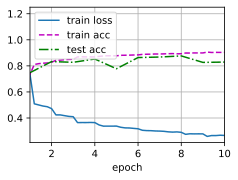

In [3]:
class BatchNorm(nn.Module):
    # `num_features`: the number of outputs for a fully-connected layer
    # or the number of output channels for a convolutional layer. `num_dims`:
    # 2 for a fully-connected layer and 4 for a convolutional layer
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # The variables that are not model parameters are initialized to 0 and 1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # If `X` is not on the main memory, copy `moving_mean` and
        # `moving_var` to the device where `X` is located
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # Save the updated `moving_mean` and `moving_var`
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    BatchNorm(6, num_dims=4), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16*4*4, 120), 
    BatchNorm(120, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    BatchNorm(84, num_dims=2), 
    nn.Sigmoid(),
    nn.Linear(84, 10))
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [4]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([2.7345, 4.8684, 1.7890, 1.6494, 2.9295, 2.6793],
        grad_fn=<ReshapeAliasBackward0>),
 tensor([ 2.3394, -2.3959, -2.1983,  2.2708,  0.0157, -2.8253],
        grad_fn=<ReshapeAliasBackward0>))

loss 0.270, train acc 0.901, test acc 0.824
4450.5 examples/sec on cpu


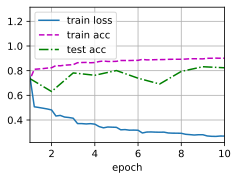

In [5]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), 
    nn.BatchNorm2d(6), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.BatchNorm2d(16), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(256, 120), 
    nn.BatchNorm1d(120), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.BatchNorm1d(84), 
    nn.Sigmoid(),
    nn.Linear(84, 10))
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())